Импорт библиотек

In [ ]:
!pip install -U aiogram
!pip install --force-reinstall -v "aiogram==2.23.1"

In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import os
import cv2
from aiogram import Bot, types, Dispatcher, executor
from aiogram.types import ContentType

Определение переменных пути к датасету, размеров изображения, и количества дополнительных изображений, полученных после аугментации

In [ ]:
PATH = "drive/MyDrive/Colab Notebooks/dataset2"

height = 224
width = 224

num_augmentations = 2

Аугментация

In [ ]:
datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

subfolders = [f.path for f in os.scandir(PATH) if f.is_dir()]

for subfolder in subfolders:
    image_files = [f.path for f in os.scandir(subfolder) if f.is_file() and f.name.endswith(('.png', '.jpg', '.jpeg'))]

    for image_file in image_files:
        img = load_img(image_file)
        x = img_to_array(img)
        x = np.expand_dims(x, axis=0)

        i = 0
        for batch in datagen.flow(x, batch_size=1, save_to_dir=subfolder, save_prefix='MY_', save_format='jpeg'):
            i += 1
            if i >= num_augmentations:
                break

Разбиение датасета на тестовую и валидационную выборки

In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  PATH,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(height, width))

val_ds = tf.keras.utils.image_dataset_from_directory(
  PATH,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(height, width))

Found 3619 files belonging to 10 classes.
Using 2896 files for training.
Found 3619 files belonging to 10 classes.
Using 723 files for validation.


Настройка набора данных для повышенной производительности

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

Сборка модели

In [ ]:
pretrained_model = tf.keras.applications.efficientnet.EfficientNetB0(
    input_shape=(height, width, 3),
    include_top=False,
    weights='imagenet',
    pooling='max'
)

pretrained_model.trainable = False

In [ ]:
augment = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.1),
  tf.keras.layers.experimental.preprocessing.RandomZoom(0.1),
  tf.keras.layers.experimental.preprocessing.RandomContrast(0.1)
  ])

inputs = pretrained_model.input
x = augment(inputs)

x = tf.keras.layers.Dense(512, activation='relu')(pretrained_model.output)
x = tf.keras.layers.Dropout(0.45)(x)
x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.Dropout(0.45)(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dropout(0.45)(x)

outputs = tf.keras.layers.Dense(10, activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 rescaling_6 (Rescaling)     (None, 224, 224, 3)          0         ['input_3[0][0]']             
                                                                                                  
 normalization_2 (Normaliza  (None, 224, 224, 3)          7         ['rescaling_6[0][0]']         
 tion)                                                                                            
                                                                                                  
 rescaling_7 (Rescaling)     (None, 224, 224, 3)          0         ['normalization_2[0][0]'

In [ ]:
model.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(),
  metrics=['accuracy'])

Обучение модели

In [ ]:
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=10
)

Epoch 1/10


ERROR:asyncio:Unclosed client session
client_session: <aiohttp.client.ClientSession object at 0x7eb33b745e10>


91/91 [==============================] - 35s 277ms/step - loss: 3.0233 - accuracy: 0.2055 - val_loss: 1.6552 - val_accuracy: 0.6473
Epoch 2/10
91/91 [==============================] - 7s 77ms/step - loss: 1.5058 - accuracy: 0.4841 - val_loss: 0.7825 - val_accuracy: 0.8077
Epoch 3/10
91/91 [==============================] - 7s 75ms/step - loss: 1.0213 - accuracy: 0.6602 - val_loss: 0.4599 - val_accuracy: 0.8783
Epoch 4/10
91/91 [==============================] - 7s 76ms/step - loss: 0.7171 - accuracy: 0.7673 - val_loss: 0.3029 - val_accuracy: 0.9073
Epoch 5/10
91/91 [==============================] - 7s 78ms/step - loss: 0.5238 - accuracy: 0.8284 - val_loss: 0.2091 - val_accuracy: 0.9405
Epoch 6/10
91/91 [==============================] - 8s 89ms/step - loss: 0.4826 - accuracy: 0.8470 - val_loss: 0.1693 - val_accuracy: 0.9585
Epoch 7/10
91/91 [==============================] - 7s 75ms/step - loss: 0.3861 - accuracy: 0.8740 - val_loss: 0.1507 - val_accuracy: 0.9530
Epoch 8/10
91/91 [====

Тестирование обученной модели

In [ ]:
leaf_url = "https://preview.free3d.com/img/2020/02/2279706405139121451/zmu409oz.jpg"
leaf_path = tf.keras.utils.get_file(origin=leaf_url)

img = tf.keras.utils.load_img(
    leaf_path, target_size=(height, width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "{}, {:.2f}%"
    .format(train_ds.class_names[np.argmax(score)], 100 * np.max(score))
)

print(train_ds.class_names)

1/1 [==============================] - 0s 77ms/step
Basil, 23.20%
['Aloe', 'Basil', 'Blackberry', 'Dandelion', 'Laurel', 'Lemon', 'Mango', 'Maple', 'Nettle', 'Oak']


Сохранение модели

In [ ]:
model.save('model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Telegram-бот

In [ ]:
TOKEN = '7067365338:AAH4e-4ZkM8Xd7iWH1M33uMjmo8MrLs8qdk'

bot = Bot(token=TOKEN)
dp = Dispatcher(bot)
class_names = ['Aloe', 'Basil', 'Blackberry', 'Dandelion', 'Laurel', 'Lemon', 'Mango', 'Maple', 'Nettle', 'Oak']
model = keras.models.load_model('drive/MyDrive/Colab Notebooks/model.h5')


def pred(image_path):
    img = tf.keras.utils.load_img(
        image_path, target_size=(224, 224)
    )
    img_array = tf.keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)
    score = tf.nn.softmax(predictions[0])

    print(
        "{}, {:.2f}%"
        .format(class_names[np.argmax(score)], 100 * np.max(score))
    )

    return(
        "{}, {:.2f}%"
        .format(class_names[np.argmax(score)], 100 * np.max(score))
    )


@dp.message_handler(commands=['start'])
async def process_start_command(message: types.Message):
    await message.reply("?")


@dp.message_handler(content_types=ContentType.PHOTO)
async def get_photo(message: types.Message):
    image_path = f'photos/{message.photo[0].file_id}.jpg'
    photos = message.photo
    await photos[0].download(destination=image_path)
    predict = pred(image_path)
    await message.reply(predict)


async def main():
    await dp.start_polling(bot)


await main()

/usr/lib/python3.10/asyncio/events.py:80: DeprecationWarning: `run_cell_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  self._context.run(self._callback, *self._args)
/usr/local/lib/python3.10/dist-packages/aiogram/types/mixins.py:40: DeprecationWarning: destination parameter is deprecated, please use destination_dir or destination_file.
  warn_deprecated(


1/1 [==============================] - 1s 1s/step
Oak, 10.57%


/usr/local/lib/python3.10/dist-packages/aiogram/types/mixins.py:40: DeprecationWarning: destination parameter is deprecated, please use destination_dir or destination_file.
  warn_deprecated(


1/1 [==============================] - 0s 44ms/step
Dandelion, 21.40%


/usr/local/lib/python3.10/dist-packages/aiogram/types/mixins.py:40: DeprecationWarning: destination parameter is deprecated, please use destination_dir or destination_file.
  warn_deprecated(


1/1 [==============================] - 0s 25ms/step
Nettle, 13.69%


/usr/local/lib/python3.10/dist-packages/aiogram/types/mixins.py:40: DeprecationWarning: destination parameter is deprecated, please use destination_dir or destination_file.
  warn_deprecated(


1/1 [==============================] - 0s 24ms/step
Oak, 11.81%


/usr/local/lib/python3.10/dist-packages/aiogram/types/mixins.py:40: DeprecationWarning: destination parameter is deprecated, please use destination_dir or destination_file.
  warn_deprecated(


1/1 [==============================] - 0s 26ms/step
Nettle, 13.61%


/usr/local/lib/python3.10/dist-packages/aiogram/types/mixins.py:40: DeprecationWarning: destination parameter is deprecated, please use destination_dir or destination_file.
  warn_deprecated(


1/1 [==============================] - 0s 34ms/step
Nettle, 15.67%


/usr/local/lib/python3.10/dist-packages/aiogram/types/mixins.py:40: DeprecationWarning: destination parameter is deprecated, please use destination_dir or destination_file.
  warn_deprecated(


1/1 [==============================] - 0s 36ms/step
Aloe, 21.72%


/usr/local/lib/python3.10/dist-packages/aiogram/types/mixins.py:40: DeprecationWarning: destination parameter is deprecated, please use destination_dir or destination_file.
  warn_deprecated(


1/1 [==============================] - 0s 25ms/step
Mango, 13.35%


/usr/local/lib/python3.10/dist-packages/aiogram/types/mixins.py:40: DeprecationWarning: destination parameter is deprecated, please use destination_dir or destination_file.
  warn_deprecated(


1/1 [==============================] - 0s 36ms/step
Mango, 11.52%


/usr/local/lib/python3.10/dist-packages/aiogram/types/mixins.py:40: DeprecationWarning: destination parameter is deprecated, please use destination_dir or destination_file.
  warn_deprecated(


1/1 [==============================] - 0s 25ms/step
Laurel, 10.69%


/usr/local/lib/python3.10/dist-packages/aiogram/types/mixins.py:40: DeprecationWarning: destination parameter is deprecated, please use destination_dir or destination_file.
  warn_deprecated(


1/1 [==============================] - 0s 39ms/step
Basil, 19.35%


/usr/local/lib/python3.10/dist-packages/aiogram/types/mixins.py:40: DeprecationWarning: destination parameter is deprecated, please use destination_dir or destination_file.
  warn_deprecated(


1/1 [==============================] - 0s 358ms/step
Aloe, 22.77%


/usr/local/lib/python3.10/dist-packages/aiogram/types/mixins.py:40: DeprecationWarning: destination parameter is deprecated, please use destination_dir or destination_file.
  warn_deprecated(


1/1 [==============================] - 0s 24ms/step
Nettle, 12.21%


/usr/local/lib/python3.10/dist-packages/aiogram/types/mixins.py:40: DeprecationWarning: destination parameter is deprecated, please use destination_dir or destination_file.
  warn_deprecated(


1/1 [==============================] - 0s 25ms/step
Nettle, 12.21%


/usr/local/lib/python3.10/dist-packages/aiogram/types/mixins.py:40: DeprecationWarning: destination parameter is deprecated, please use destination_dir or destination_file.
  warn_deprecated(


1/1 [==============================] - 0s 41ms/step
Maple, 14.33%


/usr/local/lib/python3.10/dist-packages/aiogram/types/mixins.py:40: DeprecationWarning: destination parameter is deprecated, please use destination_dir or destination_file.
  warn_deprecated(


1/1 [==============================] - 0s 24ms/step
Laurel, 13.51%


/usr/local/lib/python3.10/dist-packages/aiogram/types/mixins.py:40: DeprecationWarning: destination parameter is deprecated, please use destination_dir or destination_file.
  warn_deprecated(


1/1 [==============================] - 0s 26ms/step
Laurel, 13.51%


/usr/local/lib/python3.10/dist-packages/aiogram/types/mixins.py:40: DeprecationWarning: destination parameter is deprecated, please use destination_dir or destination_file.
  warn_deprecated(


1/1 [==============================] - 0s 25ms/step
Blackberry, 13.11%


/usr/local/lib/python3.10/dist-packages/aiogram/types/mixins.py:40: DeprecationWarning: destination parameter is deprecated, please use destination_dir or destination_file.
  warn_deprecated(


1/1 [==============================] - 0s 41ms/step
Blackberry, 11.95%


/usr/local/lib/python3.10/dist-packages/aiogram/types/mixins.py:40: DeprecationWarning: destination parameter is deprecated, please use destination_dir or destination_file.
  warn_deprecated(


1/1 [==============================] - 0s 24ms/step
Nettle, 11.65%


/usr/local/lib/python3.10/dist-packages/aiogram/types/mixins.py:40: DeprecationWarning: destination parameter is deprecated, please use destination_dir or destination_file.
  warn_deprecated(


1/1 [==============================] - 0s 39ms/step
Nettle, 15.18%


/usr/local/lib/python3.10/dist-packages/aiogram/types/mixins.py:40: DeprecationWarning: destination parameter is deprecated, please use destination_dir or destination_file.
  warn_deprecated(


1/1 [==============================] - 0s 25ms/step
Oak, 10.84%


/usr/local/lib/python3.10/dist-packages/aiogram/types/mixins.py:40: DeprecationWarning: destination parameter is deprecated, please use destination_dir or destination_file.
  warn_deprecated(


1/1 [==============================] - 0s 24ms/step
Maple, 10.58%


/usr/local/lib/python3.10/dist-packages/aiogram/types/mixins.py:40: DeprecationWarning: destination parameter is deprecated, please use destination_dir or destination_file.
  warn_deprecated(


1/1 [==============================] - 0s 36ms/step
Maple, 16.00%


Графики обучения модели

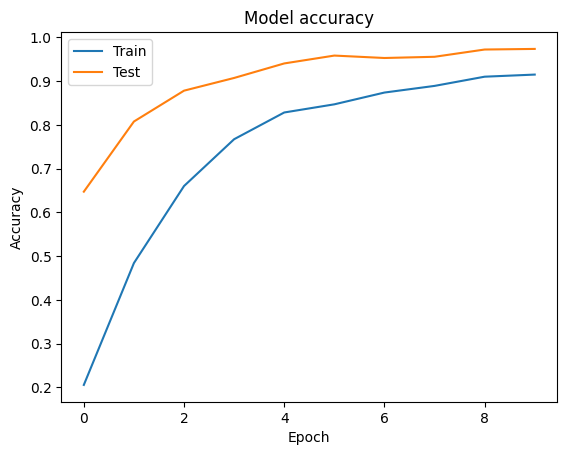

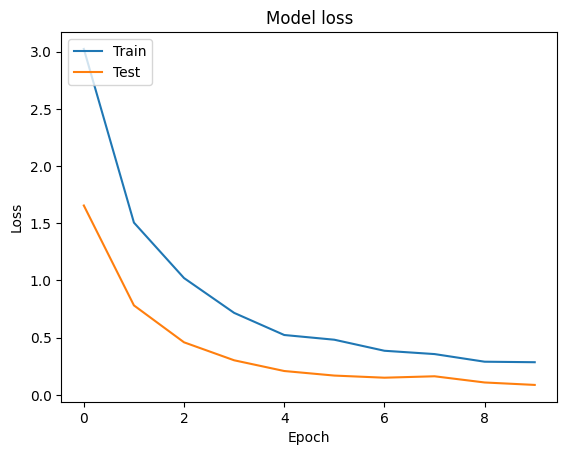

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.show()